In [1]:
#import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 18,8
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [2]:
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
dataset = pd.read_csv('C:/Faculta anul 3 sem 2/Licenta/DJIA/KO.csv', sep=',', index_col = 'Date', parse_dates = ['Date'], date_parser = dateparser).fillna(0)
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,45.939999,45.509998,45.910000,45.540001,10872200.0,40.913391
2018-01-03,45.689999,45.340000,45.490002,45.439999,12635600.0,40.823551
2018-01-04,46.220001,45.450001,45.560001,46.080002,12709400.0,41.398529
2018-01-05,46.200001,45.790001,46.020000,46.070000,13113100.0,41.389545
2018-01-08,46.099998,45.880001,45.950001,46.000000,7068600.0,41.326656


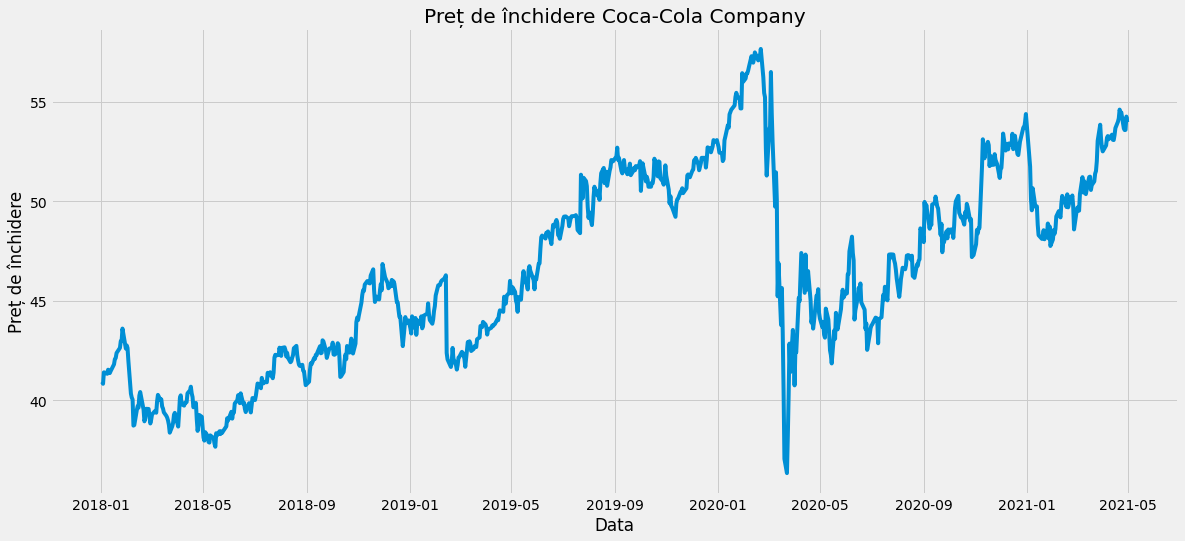

In [3]:
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(dataset['Adj Close'])
plt.title('Preț de închidere Coca-Cola Company')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

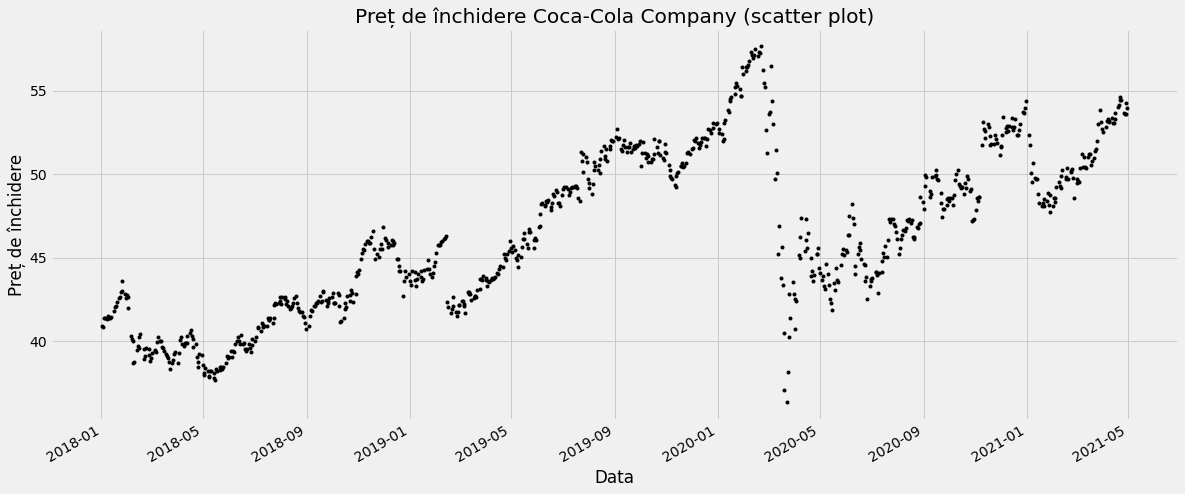

In [4]:
df_close = dataset['Adj Close']
df_close.plot(style='k.')
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.title('Preț de închidere Coca-Cola Company (scatter plot)')
plt.show

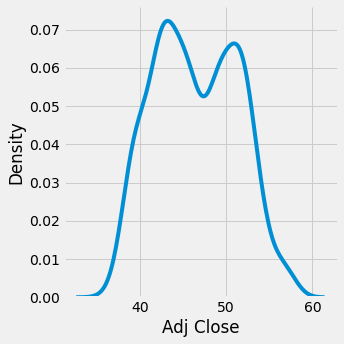

In [5]:
density = sns.displot(dataset, x="Adj Close", kind="kde")

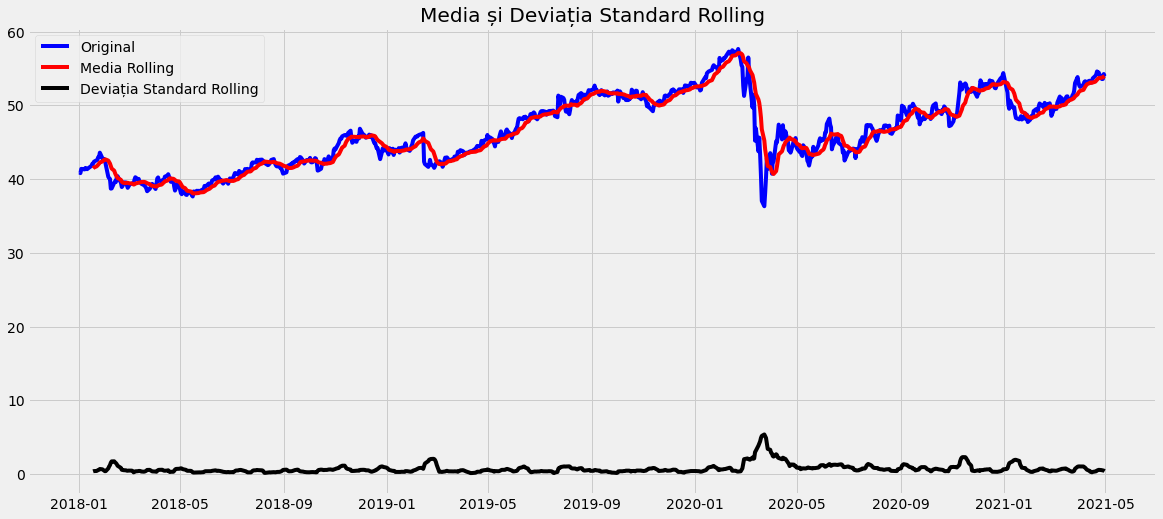

Rezultatele testului Dickey-Fuller Augmentat: 
Test statistic            -1.772623
p-value                    0.394136
Nr. decalaje folosite     12.000000
Nr. observatii           825.000000
valoare critica (1%)      -3.438301
valoare critica (5%)      -2.865050
valoare critica (10%)     -2.568639
dtype: float64


In [6]:
def test_stationarity(timeseries):
    rolling_mean = timeseries.rolling(12).mean()
    rolling_std = timeseries.rolling(12).std()
    plt.plot(timeseries, color = 'blue', label = 'Original')
    plt.plot(rolling_mean, color = 'red', label='Media Rolling')
    plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
    plt.legend(loc='best')
    plt.title('Media și Deviația Standard Rolling')
    plt.show(block=False)
    
    print('Rezultatele testului Dickey-Fuller Augmentat: ')
    adft = adfuller(timeseries, autolag = 'AIC')
    results = pd.Series(adft[0:4],index=['Test statistic','p-value','Nr. decalaje folosite','Nr. observatii'])
    for key, value in adft[4].items():
        results['valoare critica (%s)' %key] = value
    print(results)
test_stationarity(df_close)

<Figure size 1296x576 with 0 Axes>

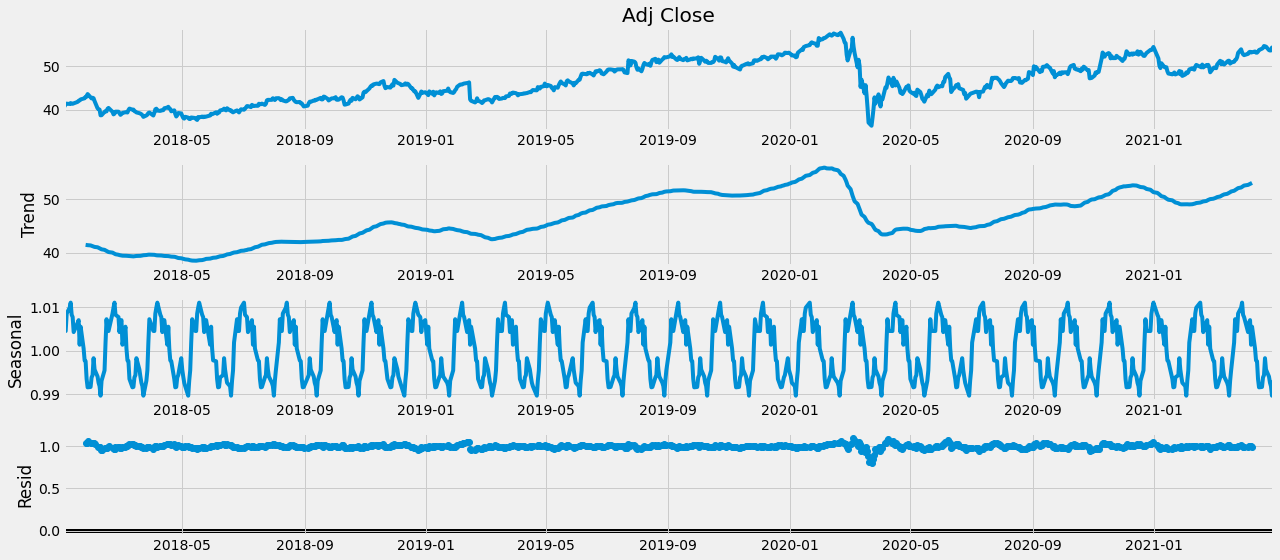

In [7]:
result = seasonal_decompose(df_close, model='multiplicative',freq = 30)
fig = plt.figure()
fig = result.plot()

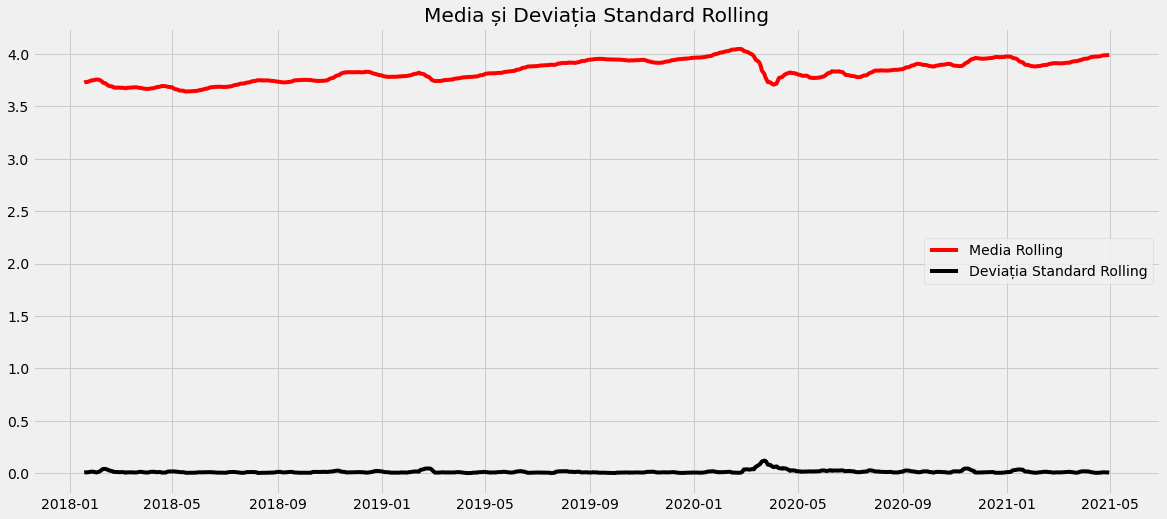

In [8]:
df_log = np.log(df_close)
rolling_mean = df_log.rolling(12).mean()
rolling_std = df_log.rolling(12).std()
plt.title('Media și Deviația Standard Rolling')
plt.plot(rolling_mean, color = 'red', label='Media Rolling')
plt.plot(rolling_std, color = 'black', label = 'Deviația Standard Rolling')
plt.legend(loc='best')
plt.show()

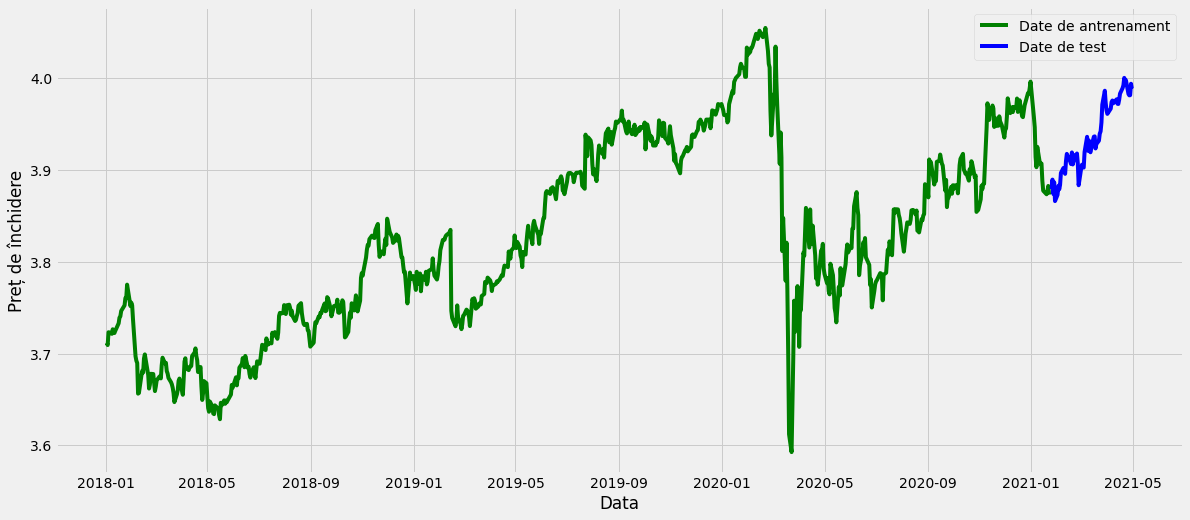

In [9]:
train_data, test_data = df_log[:int(len(df_log)*0.92)], df_log[int(len(df_log)*0.92):]
plt.xlabel('Data')
plt.ylabel('Preț de închidere')
plt.plot(train_data, 'green', label = "Date de antrenament")
plt.plot(test_data, 'blue', label = "Date de test")
plt.legend()

In [10]:
auto_ARIMA = auto_arima(train_data,
                        start_p=0, start_q=0,
                        test = 'adf',
                        max_p=3, max_q=3,
                        m=1,
                        d=None,
                        seasonal=True,
                        start_P=0, 
                        D=0,
                        trace=True,
                        error_action = 'ignore',
                        suppress_warnings=True,
                        stepwise=True,)
print(auto_ARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4253.996, Time=0.20 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4253.228, Time=0.47 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4253.072, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4255.849, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4263.621, Time=0.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4267.600, Time=3.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4255.309, Time=0.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-4253.186, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-4264.121, Time=2.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-4250.620, Time=0.84 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-4255.053, Time=0.30 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-4260.840, Time=3.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-4251.422, Time=0.95 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 13.750 seconds
        

In [12]:
first_diff = train_data - train_data.shift(1)
first_diff = first_diff.dropna(inplace = False)

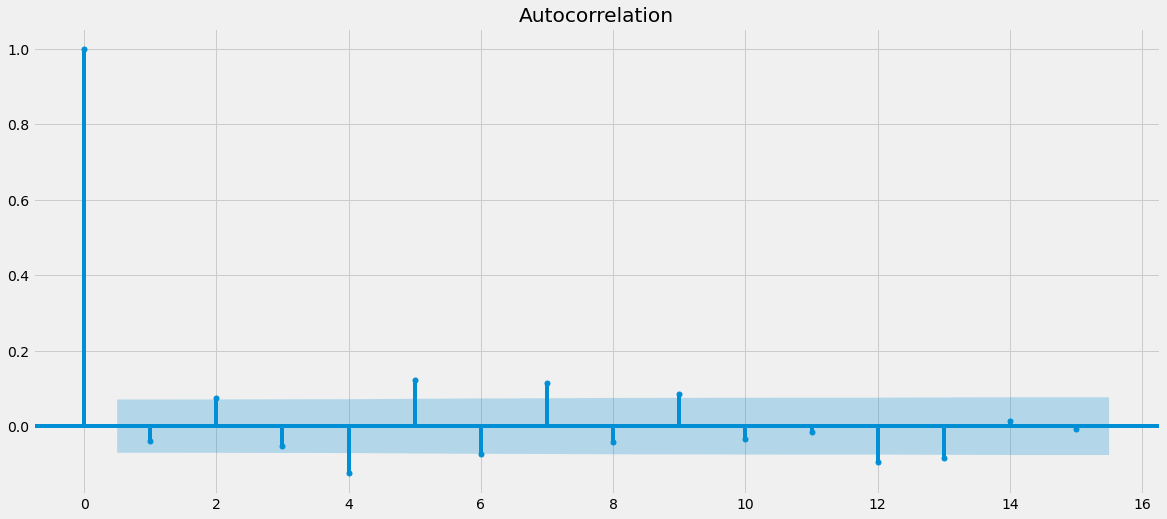

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_plot = plot_acf(first_diff,lags = 15)

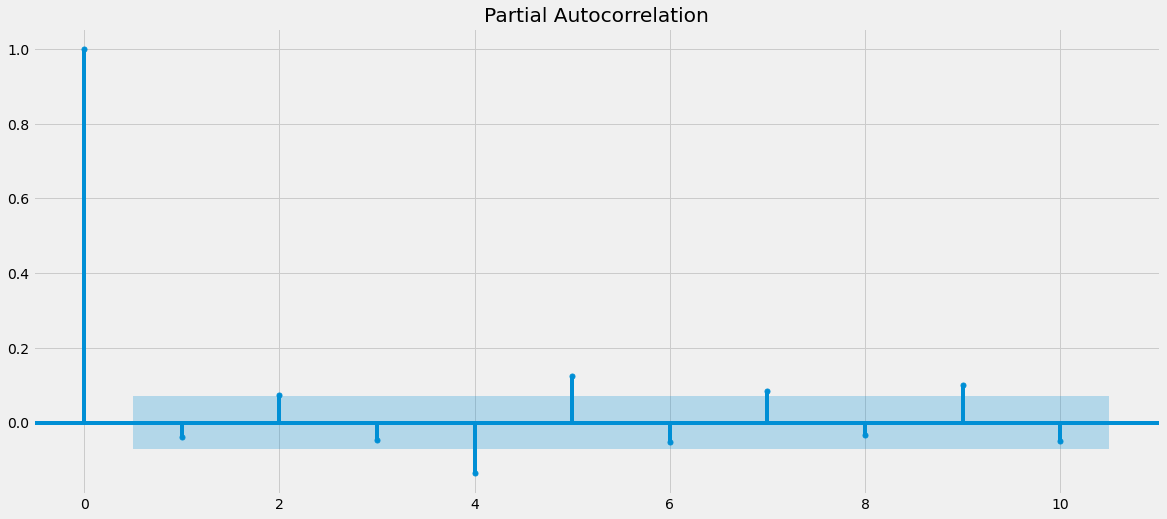

In [14]:
pacf_plot = plot_pacf(first_diff, lags=10)

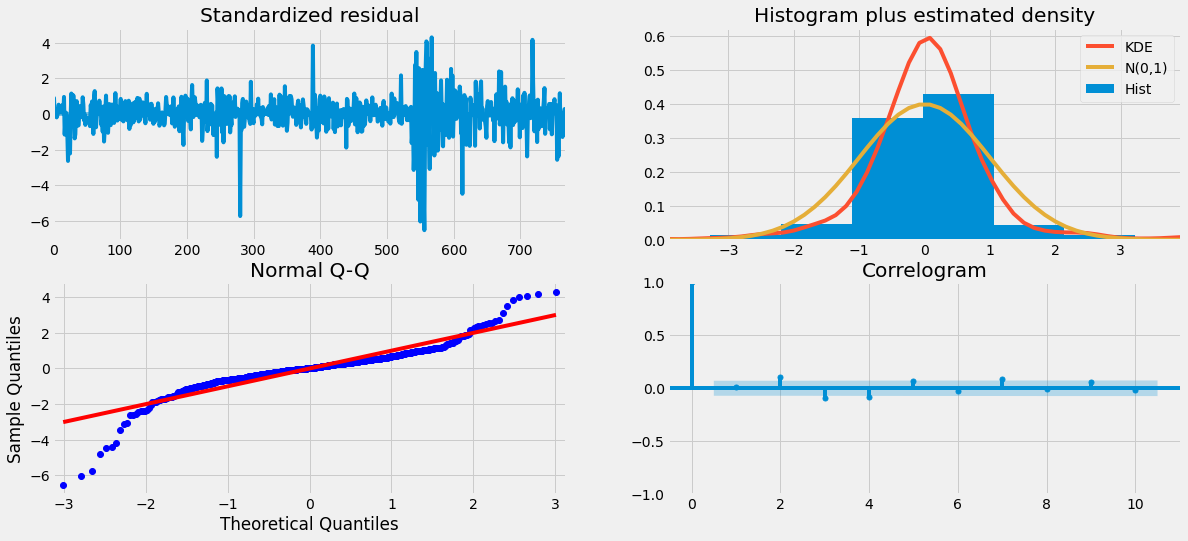

In [11]:
auto_ARIMA.plot_diagnostics()
plt.show()

In [15]:
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(2, 1, 2))  
fitted = model.fit(disp=-1,trend=  'nc')  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.Adj Close   No. Observations:                  769
Model:                 ARIMA(2, 1, 2)   Log Likelihood                2138.536
Method:                       css-mle   S.D. of innovations              0.015
Date:                Tue, 15 Jun 2021   AIC                          -4267.071
Time:                        10:42:26   BIC                          -4243.846
Sample:                             1   HQIC                         -4258.133
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
ar.L1.D.Adj Close    -0.7861      0.069    -11.445      0.000      -0.921      -0.651
ar.L2.D.Adj Close    -0.8053      0.081     -9.988      0.000      -0.963      -0.647
ma.L1.D.Adj Close     0.

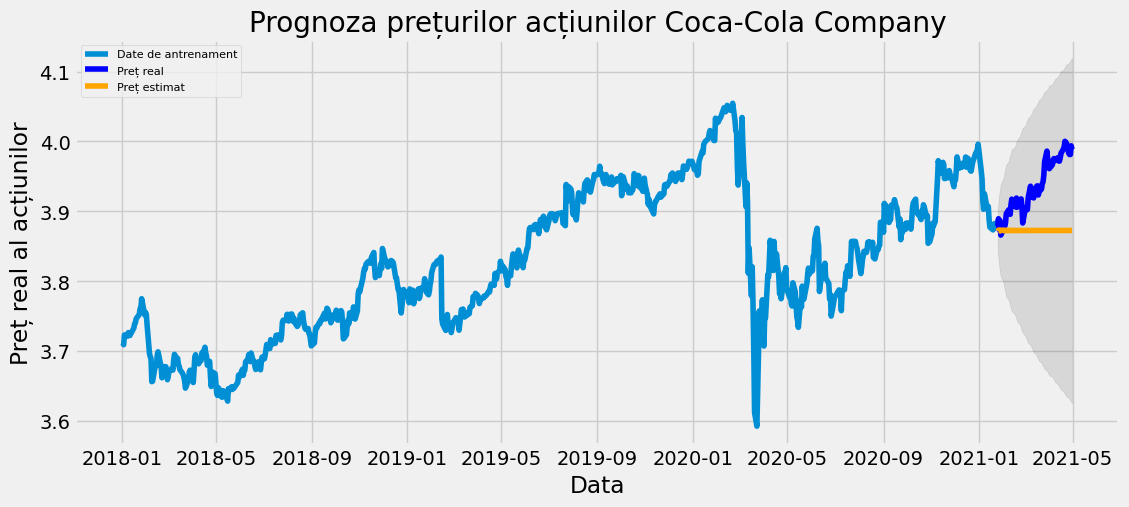

In [16]:
fc, se, conf = fitted.forecast(68, alpha=0.05)
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Date de antrenament')
plt.plot(test_data, color = 'blue', label='Preț real')
plt.plot(fc_series, color = 'orange',label='Preț estimat')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Prognoza prețurilor acțiunilor Coca-Cola Company')
plt.xlabel('Data')
plt.ylabel('Preț real al acțiunilor')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [18]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))*100
print('MAPE: '+str(mape))

MSE: 13.78753162387098
MAE: 3.1532468544707295
RMSE: 3.7131565579532166
MAPE: 6.018950672337799
